In [1]:
import numpy as np
import os, glob
import matplotlib.pyplot as plt

import h5py
import sys
sys.path.append('../')
import analysis_utils as utils

yale_colors = ['#00356b', '#286dc0', '#63aaff', '#4a4a4a']
utils.load_plotting_setting()

In [2]:
import importlib
importlib.reload(utils)

<module 'analysis_utils' from '/Users/yuhan/work/nanospheres/impulse_analysis/analysis_notebooks/../analysis_utils.py'>

In [6]:
from datetime import datetime

def plot_rates(sphere, dataset, data_prefix, n_file, bc, rates, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 5))

    ax.plot(bc, rates[0], '-', color=yale_colors[0], label='All', alpha=1)
    ax.plot(bc, rates[1], '-', color=yale_colors[1], label='Detection quality cut', alpha=1)
    ax.plot(bc, rates[2], '-', color=yale_colors[2], label='Detection quality + noise cut', alpha=1)
    ax.plot(bc, rates[3], '-', color=yale_colors[3], label='Detection quality + noise + anti-coincidence cut', alpha=1)

    ax.set_yscale('log')
    ax.set_xlim(0, 10000)
    ax.set_ylim(1e-8, 500)

In [32]:
sphere = 'sphere_20250103'
datasets = ['20250103_7e-7mbar_alignment0_long',
            '20250104_4e-8mbar_alignment0_long',
            '20250105_2e-8mbar_alignment0_long',
            '20250106_2e-8mbar_8e_alignment0_long',
            '20250107_1e-8mbar_8e_alignment0_long',
            '20250108_1e-8mbar_8e_alignment0_long',
            '20250109_1e-8mbar_8e_alignment1_long',
            '20250110_1e-8mbar_8e_alignment1_long',
            '20250111_1e-8mbar_8e_alignment1_long',
            '20250112_9e-9mbar_8e_alignment1_long',
            '20250113_5e-8mbar_8e_alignment1_long',
            '20250114_1e-8mbar_1e_alignment1_long',
            '20250115_8e-9mbar_0e_alignment1_long',
            '20250116_8e-9mbar_0e_alignment1_long_wrong_lo',
            '20250117_8e-9mbar_0e_alignment1_long',
            '20250118_8e-9mbar_1e_alignment1_long',
            '20250120_8e-9mbar_1e_alignment1_long_wbackscat',
            '20250121_8e-9mbar_1e_alignment1_long'
           ]

data_prefixs = ['20250103_d_',
                '20250104_d_',
                '20250105_d_',
                '20250106_d_',
                '20250107_d_',
                '20250108_d_',
                '20250109_d_',
                '20250110_d_',
                '20250111_d_',
                '20250112_d_',
                '20250113_d_',
                '20250114_d_',
                '20250115_d_',
                '20250116_d_',
                '20250117_d_',
                '20250118_d_',
                '20250118_d_',
                '20250119_d_',
                ]

n_files = [1440, 1440, 900, 1440, 1440, 1440, 1440, 1440, 1440, 780, 1440, 1440, 1440, 1440, 1440, 1983, 1463, 1440]

bc, scaling = None, None
hhs, rates, n_windows = [], [], []
for i, dataset in enumerate(datasets):
    data_dir = f'/Users/yuhan/work/nanospheres/data/dm_data_processed/{sphere}/{dataset}'
    
    _bc, _hhs, _rates, _n, _scaling = utils.get_summed_rates(data_dir, dataset)
    hhs.append(_hhs)
    rates.append(_rates)
    n_windows.append(_n)

    if bc is None:
        bc = _bc
    if scaling is None:
        scaling = _scaling


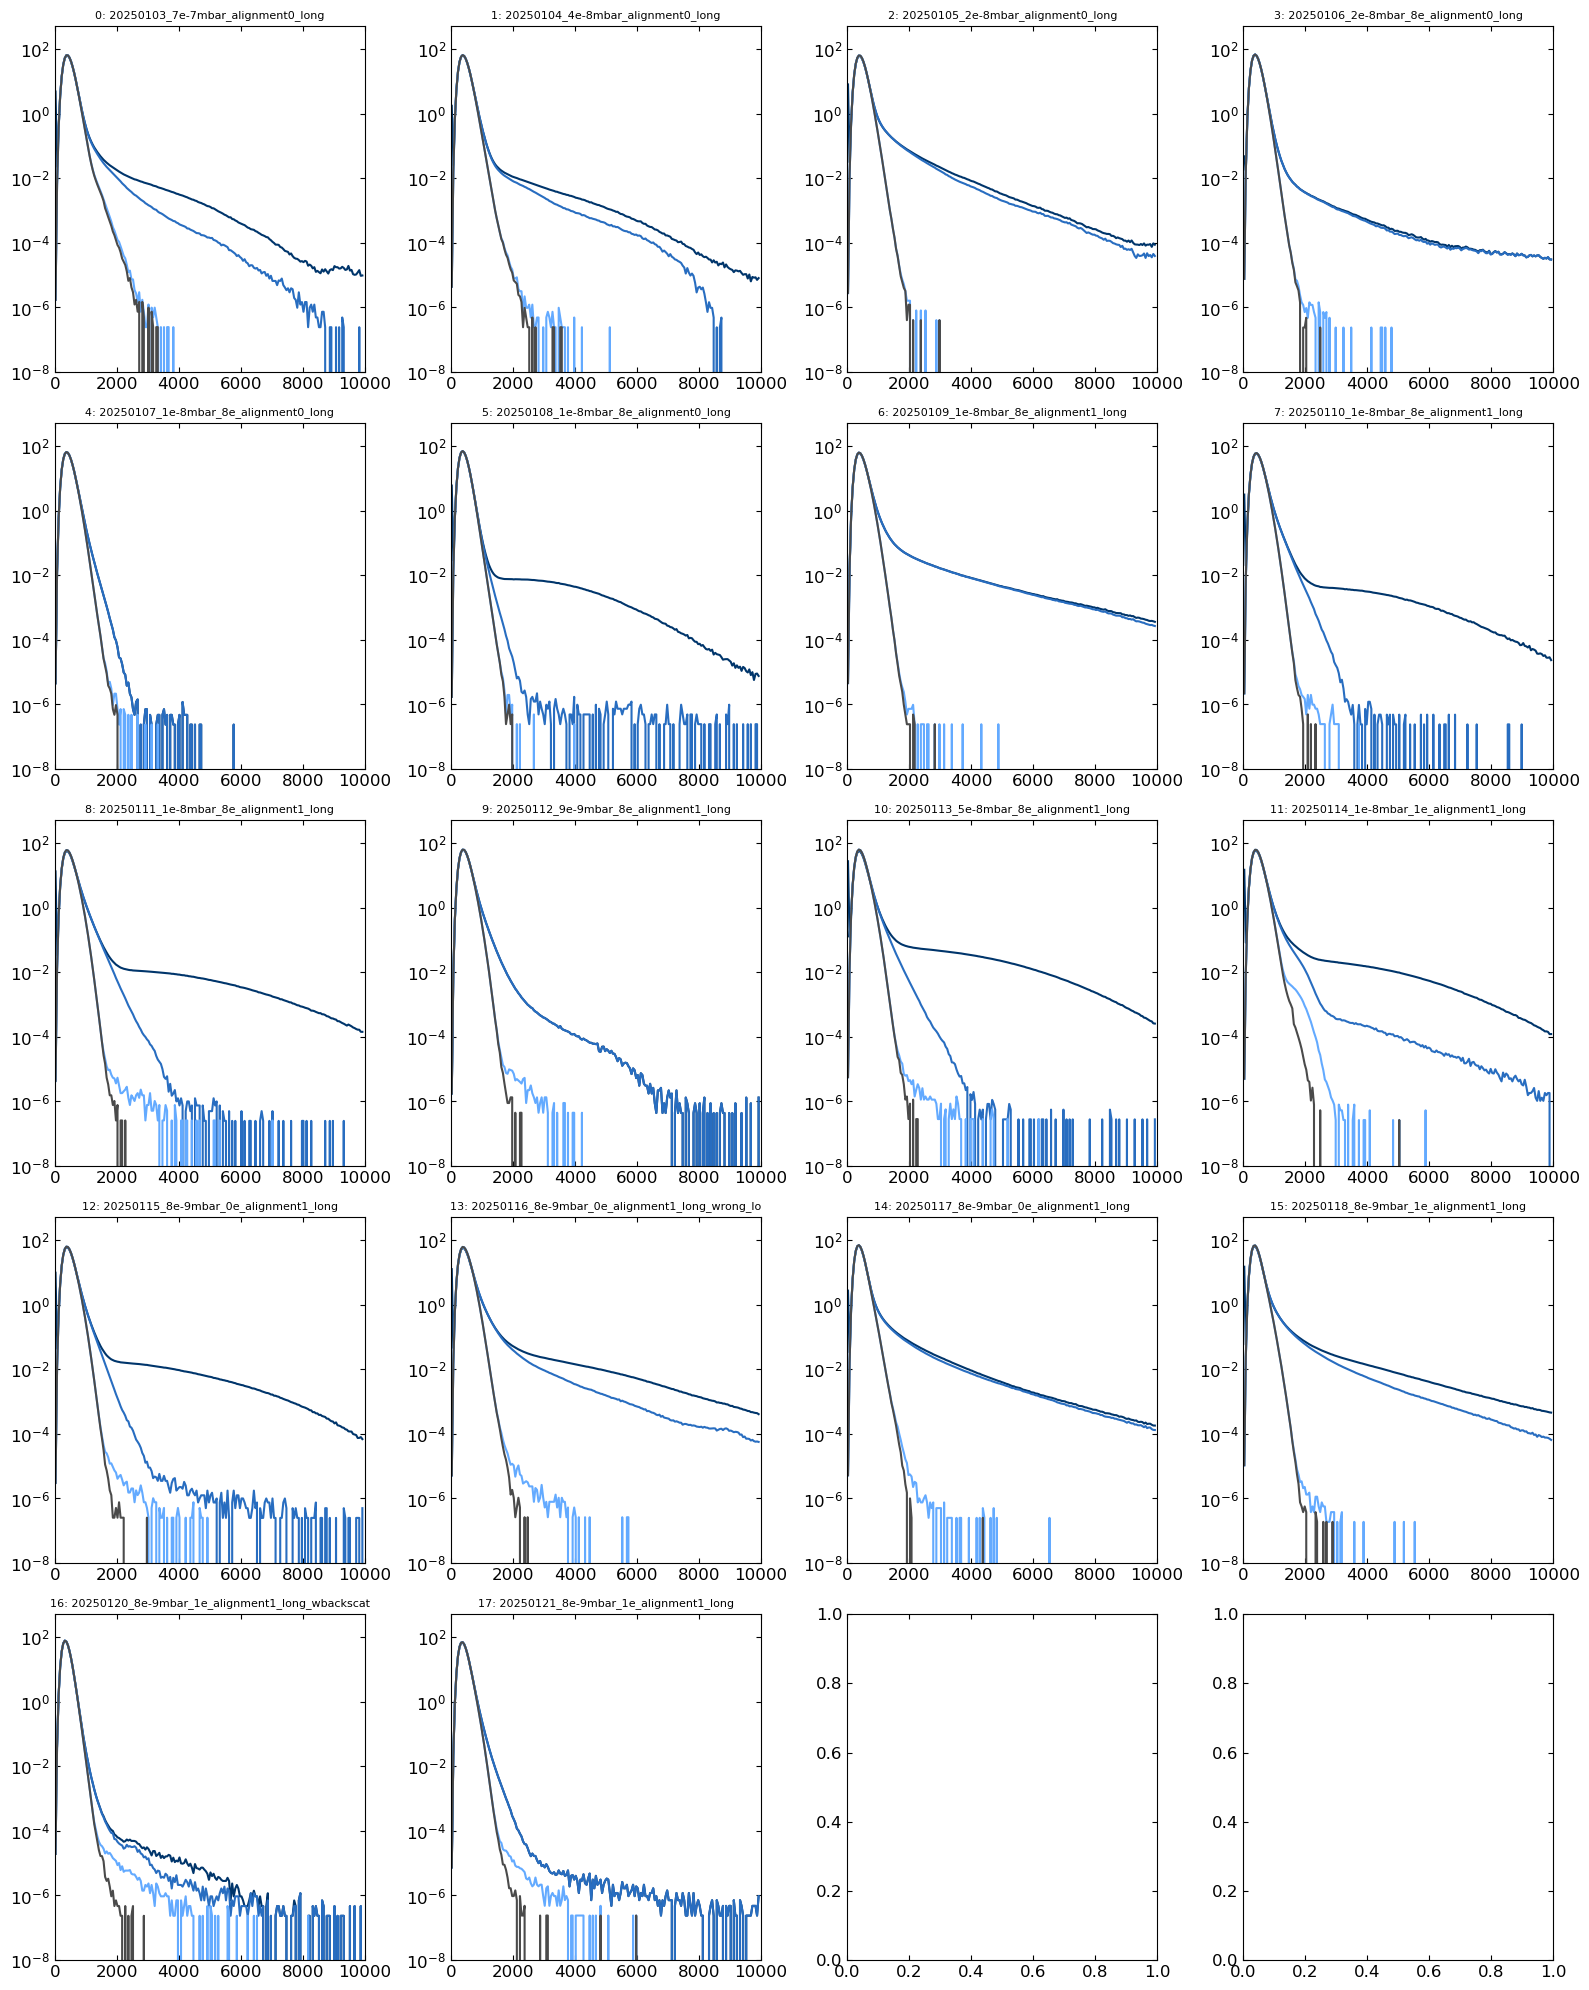

In [33]:
fig, axes = plt.subplots(5, 4, figsize=(16, 20))

for i in range(len(datasets)):
    ax = axes.flatten()[i]
    plot_rates(sphere, datasets[i], data_prefixs[i], n_files[i], bc, rates[i], ax)
    ax.set_title(f'{i}: {datasets[i]}', fontsize=8)

axes[0]
fig.tight_layout()

Text(0, 0.5, 'Differential count (Hz/keV)')

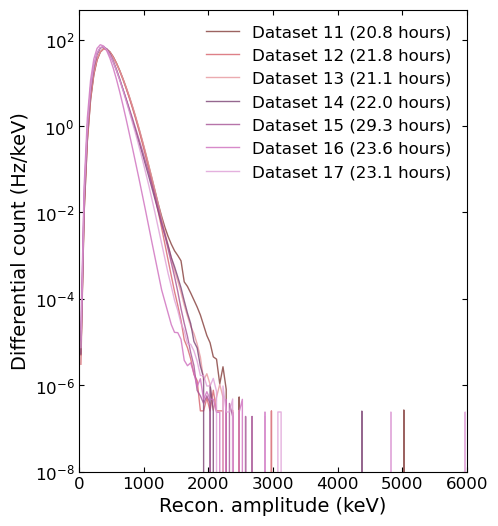

In [34]:
colors = plt.colormaps.get_cmap('tab20b').resampled(len(datasets)).colors
fig, ax = plt.subplots(figsize=(5, 6))

n_search_per_win = (5000 - 150) / 25
time_per_search = 2e-6 * 25
scaling = n_search_per_win * time_per_search * 50  # because of the 50 keV bins

times = [n[-1] * n_search_per_win * time_per_search / 3600 for n in n_windows] # Time in hours for each dataset (aftercut)

for i in range(len(datasets)):
    if i < 11: continue
    ax.plot(bc, rates[i][-1], '-', color=colors[i], label=f'Dataset {i} ({times[i]:.1f} hours)', alpha=0.8, linewidth=1)

ax.legend(frameon=False, fontsize=12)

ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlim(0, 6000)
ax.set_ylim(1e-8, 500)

ax.set_xlabel('Recon. amplitude (keV)')
ax.set_ylabel('Differential count (Hz/keV)')

<>:22: SyntaxWarning: invalid escape sequence '\s'
<>:22: SyntaxWarning: invalid escape sequence '\s'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_3569/3816306481.py:22: SyntaxWarning: invalid escape sequence '\s'
  ax.plot(xx, utils.gauss(xx, gaus_amp/(popt[0] * np.sqrt(2*np.pi)), 0, popt[0]), '--', color='#DC3220', label=f'$\sigma$ = {popt[0]:.1f} keV/c')


Text(0, 0.5, 'Differential count (Hz/keV/c)')

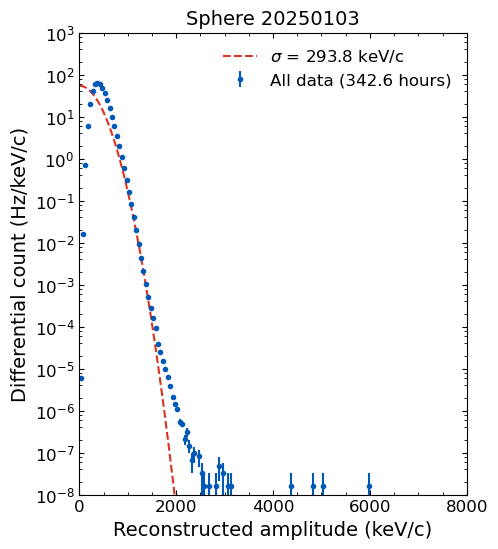

In [36]:
hh_sum = np.sum(np.asarray(hhs[2:]), axis=0)
n_window_sum = np.sum(np.asarray(n_windows[2:]), axis=0)
time_sum = np.sum(np.asarray(times[2:]))

from matplotlib.ticker import LogLocator, NullFormatter, MultipleLocator
from scipy.optimize import curve_fit

fig, ax = plt.subplots(figsize=(5, 6))
ax.errorbar(bc, hh_sum[3] / (n_window_sum[3] * scaling), yerr=np.sqrt(hh_sum[3])/(n_window_sum[3]*scaling), fmt='.', color='#005AB5', label=f'All data ({time_sum:.1f} hours)', alpha=1)

# Factor of 2 because we only have half of a Gaussian
gaus_amp = 2 * 1 / (2e-6 * 25)  # (1 s)/(time per search)
sigma = 290

fit_lb, fit_ub = 1200, 2000
idx_fit = np.logical_and(bc > fit_lb, bc < fit_ub)
popt, pcov = curve_fit(lambda x, b: utils.gauss(x, gaus_amp/(sigma * np.sqrt(2*np.pi)), 0, b), 
                       bc[idx_fit], (hh_sum[3]/(n_window_sum[3] * scaling))[idx_fit], p0=[280])

xx = np.linspace(0, 3000, 500)
# ax.plot(xx, utils.gauss(xx, gaus_amp/(sigma * np.sqrt(2*np.pi)), 0, sigma), '--', color='#DC3220', label=f'$\sigma$ = {sigma} keV/c')
ax.plot(xx, utils.gauss(xx, gaus_amp/(popt[0] * np.sqrt(2*np.pi)), 0, popt[0]), '--', color='#DC3220', label=f'$\sigma$ = {popt[0]:.1f} keV/c')

ax.legend(frameon=False, fontsize=12)

ax.set_yscale('log')
# ax.set_xscale('log')

ax.set_xlim(0, 8000)
ax.set_ylim(1e-8, 1000)

ax.set_yticks(np.logspace(-8, 3, 12))
locmin = LogLocator(base=10.0, subs=(0.2, 0.4, 0.6, 0.8), numticks=15)
ax.xaxis.set_minor_locator(MultipleLocator(500))
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(NullFormatter())

ax.set_title('Sphere 20250103')
ax.set_xlabel('Reconstructed amplitude (keV/c)')
ax.set_ylabel('Differential count (Hz/keV/c)')

In [31]:
outfile_name = 'sphere_20250103_recon_all.h5py'
out_dir = '/Users/yuhan/work/nanospheres/data/dm_data_processed/sphere_20250103'

with h5py.File(os.path.join(out_dir, outfile_name), 'w') as fout:
    g = fout.create_group('recon_data_all')
    d = g.create_dataset('bc', data=bc, dtype=np.float64)
    d.attrs['unit'] = 'keV'

    d = g.create_dataset('hist', data=(hh_sum[3]), dtype=np.int64)
    d.attrs['unit'] = 'Count'
    d.attrs['n_windows'] = n_window_sum[3]
    d.attrs['scaling'] = scaling

    d = g.create_dataset('rate_hist', data=(hh_sum[3] / (n_window_sum[3] * scaling)), dtype=np.float64)
    d.attrs['unit'] = 'Hz/keV'

    g.create_dataset('rate_hist_err', data=(np.sqrt(hh_sum[3])/(n_window_sum[3]*scaling)), dtype=np.float64)
    g.attrs['time_hours'] = time_sum

    fout.close()

In [66]:
data_dir = f'/Users/yuhan/work/nanospheres/data/dm_data_processed/{sphere}/{datasets[6]}'
data_prefix = r'20250109_d_'

hists_6 = utils.load_data_hists(data_dir, data_prefix, n_files[6], 1600)

events_after_cut_6 = utils.get_events_after_cut(hists_6, thr=2000)
print('Number of windows with large events: ', len(events_after_cut_6))

Number of windows with large events:  5


/Volumes/LaCie/dm_data/sphere_20250103/20250109_1e-8mbar_8e_alignment1_long/20250109_d_308.hdf5
/Volumes/LaCie/dm_data/sphere_20250103/20250109_1e-8mbar_8e_alignment1_long/20250109_d_568.hdf5
/Volumes/LaCie/dm_data/sphere_20250103/20250109_1e-8mbar_8e_alignment1_long/20250109_d_844.hdf5
/Volumes/LaCie/dm_data/sphere_20250103/20250109_1e-8mbar_8e_alignment1_long/20250109_d_1174.hdf5
/Volumes/LaCie/dm_data/sphere_20250103/20250109_1e-8mbar_8e_alignment1_long/20250109_d_1361.hdf5


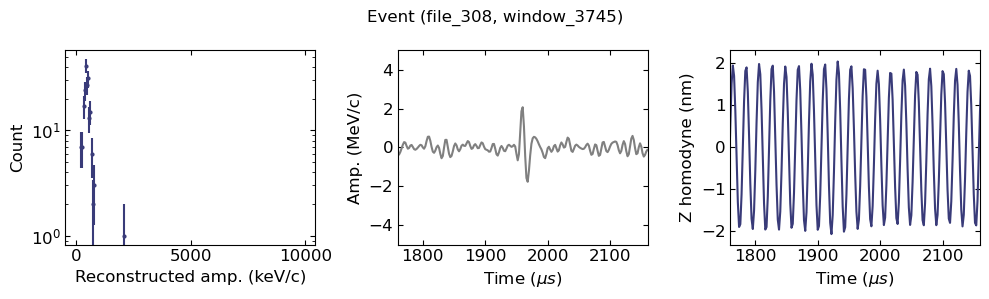

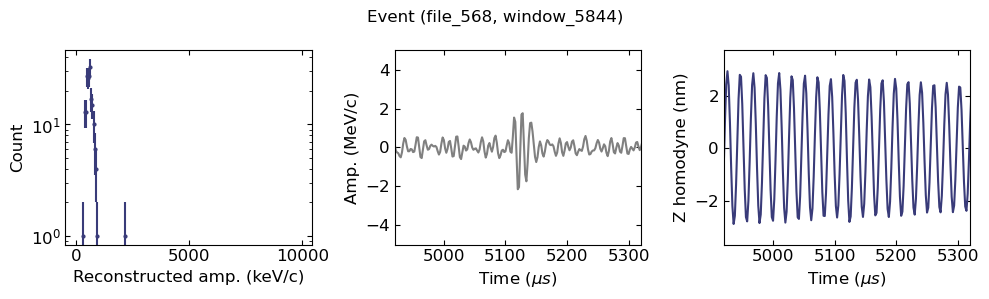

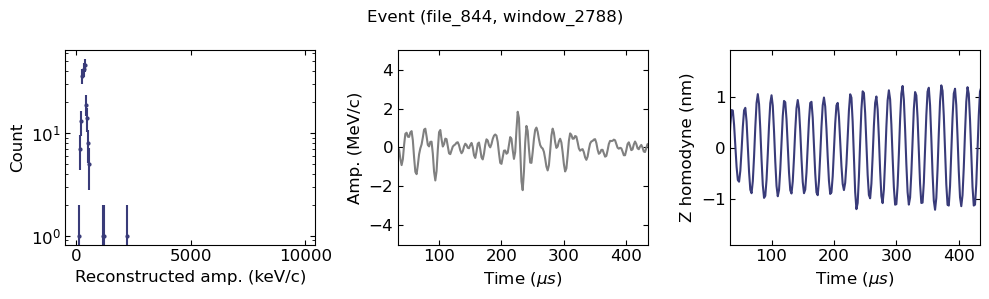

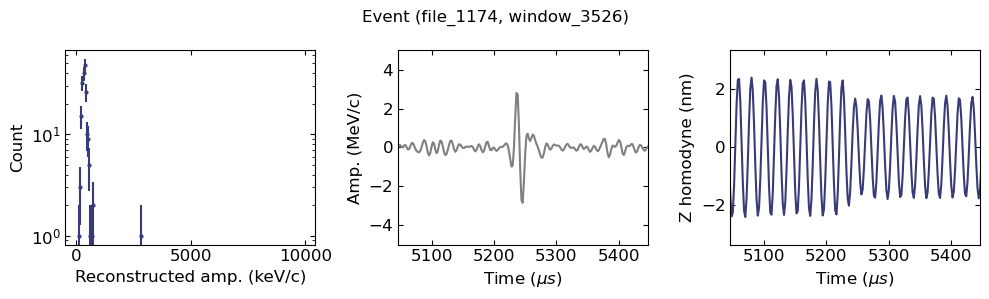

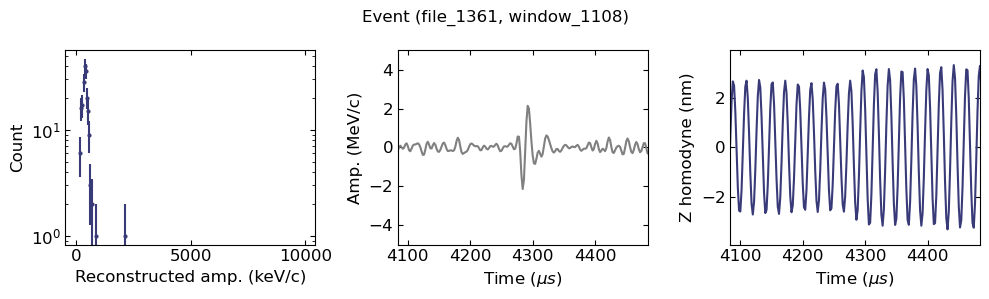

In [67]:
raw_data_dir = rf'/Volumes/LaCie/dm_data/{sphere}/{datasets[6]}'

c_mv = 5.522e-08
amp2kev = 7504.810851477031

window_length = 5000
bins = np.arange(0, 10000, 50)
bc = 0.5 * (bins[:-1] + bins[1:])

for i, j in events_after_cut_6[:]:
    _, _, _, _, _, _ = utils.plot_hist_events(raw_data_dir, data_prefix, i, j, window_length, bins, bc, c_mv, amp2kev, False, True)

In [71]:
data_dir = f'/Users/yuhan/work/nanospheres/data/dm_data_processed/{sphere}/{datasets[11]}'
data_prefix = r'20250114_d_'

hists_11 = utils.load_data_hists(data_dir, data_prefix, n_files[11], 1600, 400)

events_after_cut_11 = utils.get_events_after_cut(hists_11, thr=4000)
print('Number of windows with large events: ', len(events_after_cut_11))

Number of windows with large events:  1


/Volumes/LaCie/dm_data/sphere_20250103/20250114_1e-8mbar_1e_alignment1_long/20250114_d_733.hdf5


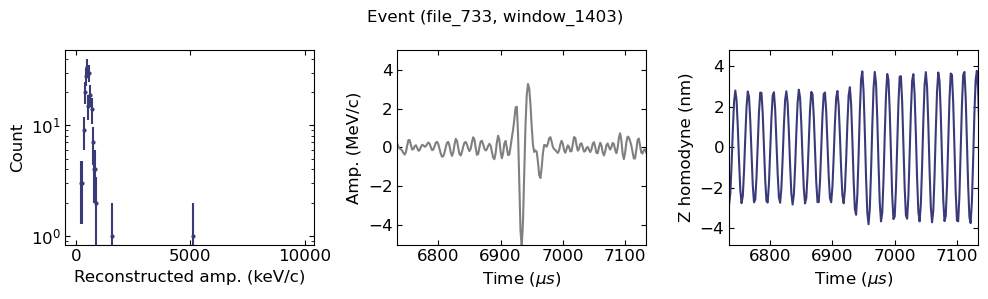

In [72]:
raw_data_dir = rf'/Volumes/LaCie/dm_data/{sphere}/{datasets[11]}'

c_mv = 5.522e-08
amp2kev = 7504.810851477031

window_length = 5000
bins = np.arange(0, 10000, 50)
bc = 0.5 * (bins[:-1] + bins[1:])

for i, j in events_after_cut_11[:]:
    _, _, _, _, _, _ = utils.plot_hist_events(raw_data_dir, data_prefix, i, j, window_length, bins, bc, c_mv, amp2kev, False, True)